In [1]:
import multiprocessing
from multiprocessing import Pool
import threading
import vio_ort
import vio_ort2
import json
import matplotlib.pyplot as plt # type: ignore
import os
import cv2 # type: ignore
import numpy as np # type: ignore
from time import time

In [2]:
odometry = vio_ort2.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
#set_dir = '2025_1_16_15_43_35'
#set_dir = '2024_12_15_15_18_8_num_24'
set_dir = '2024_12_15_15_31_8_num_3'
#set_dir = '2024_12_15_15_31_8_num_5'

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

Использование multiprocessing

Список времени выполнения: 39.7s, 39.3s, 39.2s, 39.1s, 38.1s

Без использования потоков внутри проблемной функции: 1m 14.8s

Использование батч

Список времени выполнения: 38.8s, 38.7s, 37.8s, 37.7s, 38.3s

Без использования потоков внутри проблемной функции: 1m 14.8s

Использование asyncio

Список времени выполнения: 34.9s, 34.6s, 33.7s, 33.9s, 33.4s

Без использования потоков внутри проблемной функции: 32.3s

Использование threading

In [3]:
# Код с потоковой оптимизацией
def process_file_threaded(filename):
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return
            
            image = cv2.imread(img_path)
            if image is None:
                return
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                with threading.Lock():
                    lat_VIO.append(result_vio['lat'])
                    lon_VIO.append(result_vio['lon'])
                    lat_GPS.append(data['GNRMC']['lat'])
                    lon_GPS.append(data['GNRMC']['lon'])
                    # собираем время
                    elapsed_times.append(result_vio['elapsed_time'])
                    # собираем этапы
                    all_timings.append(result_vio['timings'])
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Запускаем обработку в потоках

local_time = time()

threads = []
elapsed_times = []
all_timings = []
for filename in json_files[start:start + count_json]:
    thread = threading.Thread(target=process_file_threaded, args=(filename,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Список времени выполнения: 13.6s, 12.8s, 13.1s, 13.7s, 12.7s, 14.2s, 13.4s, 12.4s

def calc_pos(self, next_pt):
        """Рассчитывает локальную позицию."""
        recent_trace = self.trace[-TRACE_DEPTH:]

        def process_prev_pt(prev_pt):
            match_prev, match_next, HoM = self.match_points_hom(prev_pt['out'], next_pt['out'])
            if len(match_prev) <= NUM_MATCH_THR:
                return None
            center_proj = cv2.perspectiveTransform(CROP_CENTER.reshape(-1, 1, 2), HoM).ravel()
            pix_shift = CROP_CENTER - center_proj
            pix_shift[0], pix_shift[1] = -pix_shift[1], pix_shift[0]
            return prev_pt['local_posm'] + pix_shift / FOCAL * next_pt['height']

        with ThreadPoolExecutor() as executor:
            poses = list(executor.map(process_prev_pt, recent_trace))
        return np.mean([p for p in poses if p is not None], axis=0) if poses else None

In [4]:
print(f"Общее время выполнения: {time() - local_time} секунд")
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Общее время выполнения: 12.445454835891724 секунд
Среднее время обработки одного файла: 5.6759 секунд
Максимальное время обработки: 11.6098 секунд
Минимальное время обработки: 0.6270 секунд


In [5]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
top_timings = {key: np.max([t[key] for t in all_timings]) for key in all_timings[0].keys()}
min_timings = {key: np.min([t[key] for t in all_timings]) for key in all_timings[0].keys()}

In [6]:
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000034598 секунд
fetch_height: 0.0000040482 секунд
preprocess_frame: 0.0113372440 секунд
rotation: 0.0294625051 секунд
fisheye_correction: 0.1562465434 секунд
detect_and_compute: 0.7218625245 секунд
local_position_calculation: 4.7569182865 секунд
velocity_calculation: 0.0000205488 секунд
GPS_calculation: 0.0000395277 секунд


In [7]:
print("Максимальное время по этапам:")
for key, value in top_timings.items():
    print(f"{key}: {value:.10f} секунд")

Максимальное время по этапам:
fetch_angles: 0.0000147820 секунд
fetch_height: 0.0000324249 секунд
preprocess_frame: 0.1074016094 секунд
rotation: 0.1607780457 секунд
fisheye_correction: 0.3408493996 секунд
detect_and_compute: 1.1406118870 секунд
local_position_calculation: 10.6391949654 секунд
velocity_calculation: 0.0001208782 секунд
GPS_calculation: 0.0001869202 секунд


In [8]:
print("Минимальное время по этапам:")
for key, value in min_timings.items():
    print(f"{key}: {value:.10f} секунд")

Минимальное время по этапам:
fetch_angles: 0.0000014305 секунд
fetch_height: 0.0000019073 секунд
preprocess_frame: 0.0007717609 секунд
rotation: 0.0012528896 секунд
fisheye_correction: 0.0341255665 секунд
detect_and_compute: 0.1485302448 секунд
local_position_calculation: 0.0000579357 секунд
velocity_calculation: 0.0000107288 секунд
GPS_calculation: 0.0000178814 секунд


In [9]:
print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

GPS lat: 54.8894191667
VIO lat: 54.889668


In [10]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257335
VIO lon: 83.1258973333


In [11]:
print(len(lat_GPS))
print(len(lat_VIO))

532
532


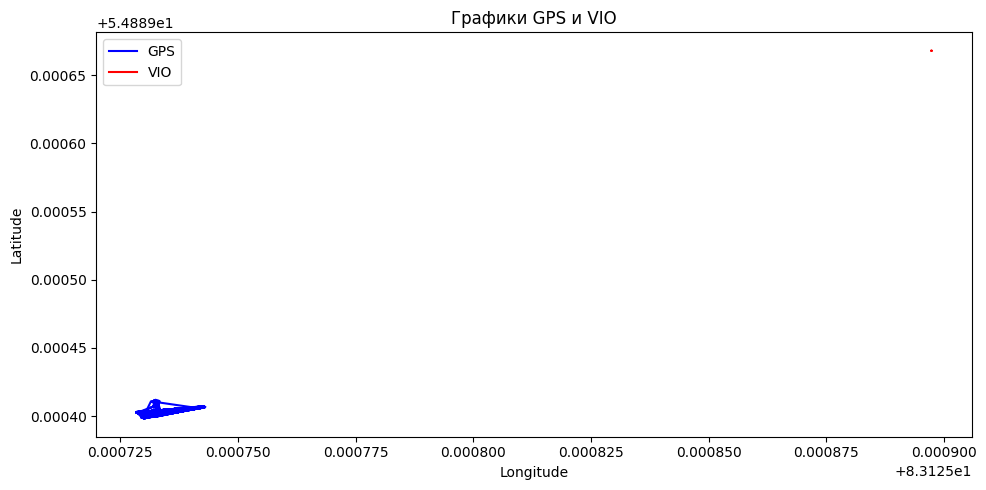

In [12]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

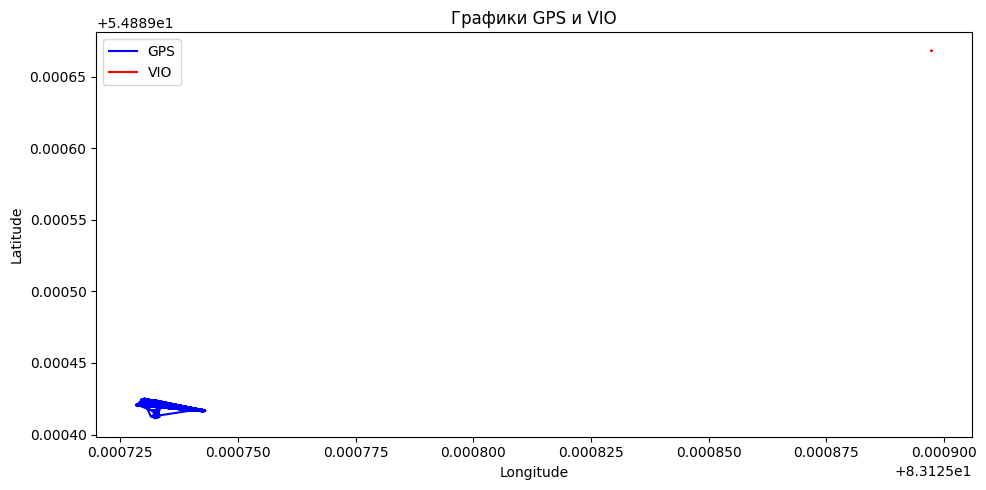

In [13]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()